In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Link up Chicago crime events with chicago address locations

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import os, lzma
import numpy as np
import tilemapbase
import open_cp.geometry
open_cp.geometry.configure_gdal()
import pyproj
proj = pyproj.Proj({"init":"epsg:2790"})
import rtree

import impute.address
import impute.chicago

### Load address database

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
filename = os.path.join(datadir, "openaddr-collected-us_midwest.zip")

for row in impute.address.readzip(filename, "il", "cook"):
    break
row

Row(point=(-88.1904381, 42.0741614), street='WEST HIGGINS ROAD', number='4589', unit='', city='Hoffman Estates', district='', region='', postcode='60192', idd='', hash='7e424765c7c8f0c0')

In [4]:
address_points = []
addresses = []
for row in impute.address.readzip(filename, "il", "cook"):
    address_points.append(row.point)
    addresses.append((row.number, row.street))

In [5]:
address_points = np.asarray(address_points)
address_points = np.vstack(proj(*address_points.T)).T
address_points.shape, len(addresses)

((1337277, 2), 1337277)

### Load crime data

In [6]:
filename = os.path.join(datadir, "chicago_all.csv.xz")
def gen():
    with lzma.open(filename, "rt") as f:
        yield from impute.chicago.load_only_with_point(f)
next(gen())

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

In [7]:
crime_points = []
crime_addresses = []
crime_types = []
for row in gen():
    if row.datetime.year == 2001:
        continue
    crime_points.append(row.point)
    crime_addresses.append((row.location, row.address))
    crime_types.append(row.crime_type)
crime_points = np.asarray(crime_points)
crime_points = np.vstack(proj(*crime_points.T)).T
crime_points.shape, len(crime_addresses)

((5840574, 2), 5840574)

In [8]:
crime_pts_wm = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for pt in crime_points])
add_pts_wm = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for pt in address_points])

# Try to join up

For each crime point, find the closest address point.

This is of course slow, so we use `rtree` to speed it up.

In [9]:
def index_gen():
    e = 1
    for i, (x, y) in enumerate(address_points):
        xmin, xmax = x-e, x+e
        ymin, ymax = y-e, y+e
        yield i, (xmin, ymin, xmax, ymax), None

index = rtree.index.Index(index_gen())

In [10]:
def closest_address(pt):
    d = 10
    choices = []
    while len(choices) == 0:
        xmin, xmax = pt[0] - d, pt[0] + d
        ymin, ymax = pt[1] - d, pt[1] + d
        choices = list(index.intersection((xmin, ymin, xmax, ymax)))
        d += d
    diffs = [pt - address_points[i] for i in choices]
    distsqs = np.sum(np.asarray(diffs)**2, axis=1)
    i = np.argmin(distsqs)
    i = choices[i]
    return address_points[i], addresses[i]

closest_address(crime_points[0]), crime_points[0], crime_addresses[0]

((array([ 366709.26919737,  558910.25552585]), ('10824', 'SOUTH AVENUE G')),
 array([ 366730.911874  ,  558913.79221203]),
 ('RESIDENCE', '108XX S AVENUE G'))

In [11]:
closest_points = [closest_address(pt) for pt in crime_points]

## Distribution of distances

In [12]:
distances = np.asarray([np.sqrt(np.sum((pt-add_pt)**2))
    for pt, (add_pt, _) in zip(crime_points, closest_points)])

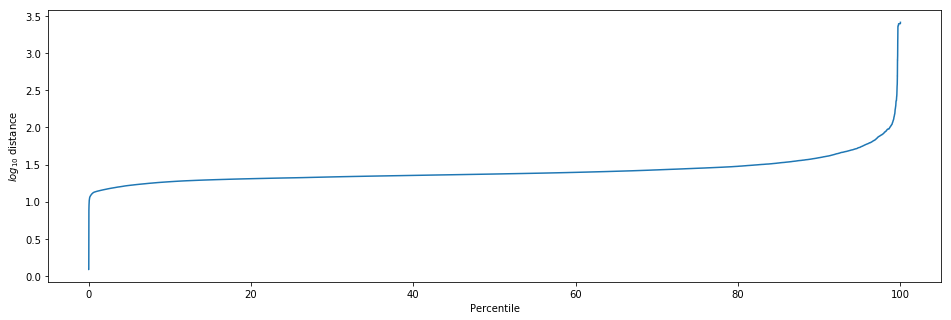

In [13]:
d = np.sort(distances)

fig, ax = plt.subplots(figsize=(16,5))
x = np.arange(len(d)) / len(d) * 100
ax.plot(x, np.log10(d))
ax.set(ylabel="$log_{10}$ distance", xlabel="Percentile")
None

In [14]:
d[int(len(d)*0.99)]

113.41524730721412

In [15]:
i = np.argmax(distances)
i, closest_points[i], crime_points[i], crime_addresses[i]

(1823123,
 (array([ 334339.60294037,  587363.26551851]), ('105', 'DIVISION STREET')),
 array([ 335033.17244838,  589854.71165567]),
 ('AIRPORT TERMINAL LOWER LEVEL - SECURE AREA', '0000X W C18 ST'))

In [16]:
indices = np.arange(len(distances))[distances > 150]

In [17]:
known_problems = {" W OHARE ST", # Airport
                 }

limit = 10
count = 0
for i in indices:
    if any(crime_addresses[i][1].endswith(x) for x in known_problems):
        continue
    data = closest_points[i], crime_points[i], crime_addresses[i], distances[i]
    print(data)
    count += 1
    if count >= limit:
        break

((array([ 341087.2431124 ,  590380.95608338]), ('5800', 'NORTH CUMBERLAND AVENUE')), array([ 341165.1511069 ,  590513.99541516]), ('STREET', '058XX N CUMBERLAND AVE'), 154.17236914154489)
((array([ 353440.82336478,  565296.43973458]), ('2750', 'WEST COLUMBUS AVENUE')), array([ 353265.12576297,  565267.97056905]), ('ALLEY', '075XX S CALIFORNIA AVE'), 177.9891588479048)
((array([ 356916.2213674 ,  587704.80972195]), ('647', 'WEST BUENA AVENUE')), array([ 357668.884937  ,  587899.41581576]), ('PARKING LOT/GARAGE(NON.RESID.)', '002XX W MONTROSE HARBOR DR'), 777.41493474012282)
((array([ 341087.2431124 ,  590380.95608338]), ('5800', 'NORTH CUMBERLAND AVENUE')), array([ 341165.1511069 ,  590513.99541516]), ('CTA GARAGE / OTHER PROPERTY', '058XX N CUMBERLAND AVE'), 154.17236914154489)
((array([ 359718.83617751,  577647.53506049]), ('1200', 'SOUTH LAKE SHORE DRIVE')), array([ 359816.2052252 ,  577484.07415959]), ('VEHICLE NON-COMMERCIAL', '005XX E SOLIDARITY DR'), 190.26349511358612)
((array([

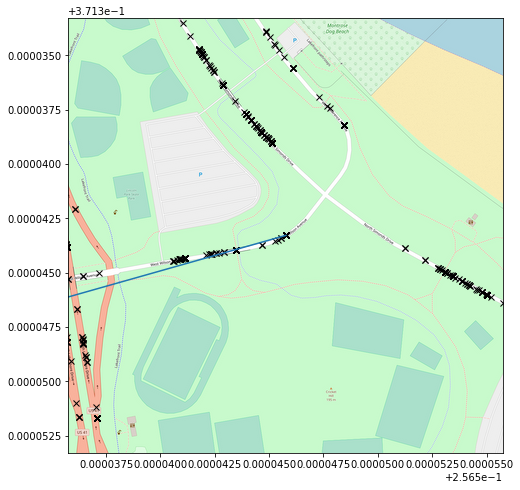

In [18]:
x, y = proj(*data[1], inverse=True)
ex = tilemapbase.Extent.from_centre_lonlat(x, y, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
fig, ax = plt.subplots(figsize=(8,8))
plotter.plot(ax)

ax.scatter(*crime_pts_wm.T, marker="x", linewidth=1, color="black")
ax.scatter(*add_pts_wm.T, marker="o", linewidth=1, color="black")
x, y = tilemapbase.project(x, y)
tx, ty = tilemapbase.project(*proj(*data[0][0], inverse=True))
ax.plot([x, tx], [y, ty])

## Summary / Conclusions

This seems to work pretty well, but there are quite a few crimes which don't occur close to a building.
- Not surprising
- Hopefully less of an issue for e.g. Burglary crime

In [19]:
distances = np.asarray([np.sqrt(np.sum((pt-add_pt)**2))
    for pt, (add_pt, _), ctype in zip(crime_points, closest_points, crime_types)
    if ctype == "BURGLARY" ])

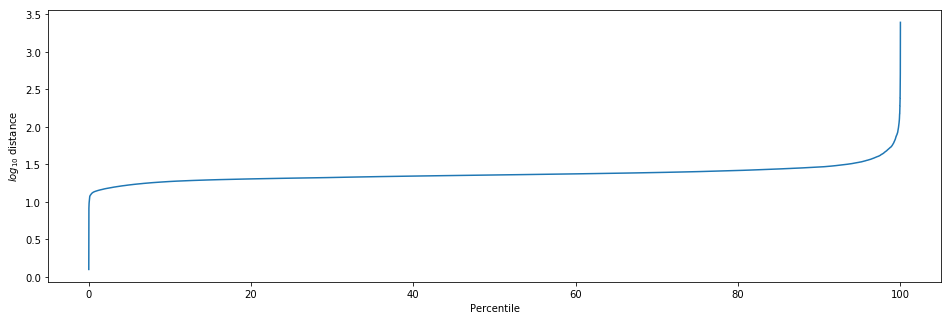

In [20]:
d = np.sort(distances)

fig, ax = plt.subplots(figsize=(16,5))
x = np.arange(len(d)) / len(d) * 100
ax.plot(x, np.log10(d))
ax.set(ylabel="$log_{10}$ distance", xlabel="Percentile")
None

In [21]:
d[int(len(d)*0.99)]

56.715660524685894

## Some plots

In [22]:
lines = []
for pt, (add_pt, _) in zip(crime_points, closest_points):
    a = tilemapbase.project(*proj(*pt, inverse=True))
    b = tilemapbase.project(*proj(*add_pt, inverse=True))
    lines.append((a, b))

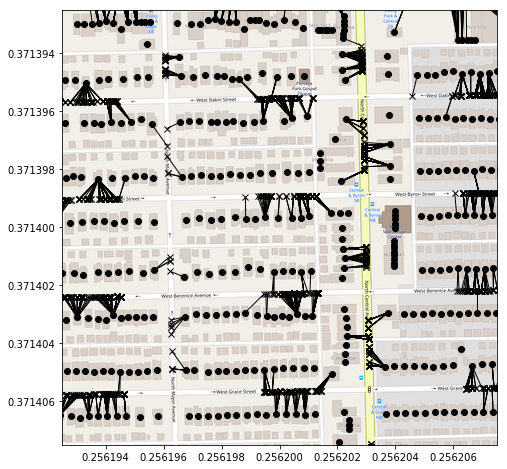

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ex = tilemapbase.Extent.from_centre(0.2562, 0.3714, xsize=0.000015)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

plotter.plot(ax)
ax.scatter(*crime_pts_wm.T, marker="x", color="black", linewidth=1)
ax.scatter(*add_pts_wm.T, marker="o", color="black", linewidth=1)
ax.add_collection(matplotlib.collections.LineCollection(lines, linewidth=1, color="black"))

This plot shows a problem: the "clustering" of the input data means that we only use a small fraction of the building addresses.

### Option one

Assign to a "close" instead of "closest" point

### Option two

Run one of the other redistribution algorithms first (maybe also projecting back to the street network).

In [24]:
def point_in_disc(pt, radius):
    xmin, xmax = pt[0] - radius, pt[0] + radius
    ymin, ymax = pt[1] - radius, pt[1] + radius
    choices = list(index.intersection((xmin, ymin, xmax, ymax)))
    assert len(choices) > 0
    i = np.random.choice(choices)
    return address_points[i], addresses[i]

In [25]:
new_points = []
for pt in crime_points:
    npt, _ = closest_address(pt)
    npt, _ = point_in_disc(npt, 100)
    new_points.append(npt)

In [26]:
lines = []
for pt, add_pt in zip(crime_points, new_points):
    a = tilemapbase.project(*proj(*pt, inverse=True))
    b = tilemapbase.project(*proj(*add_pt, inverse=True))
    lines.append((a, b))

In [27]:
new_pts_wm = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for pt in new_points])

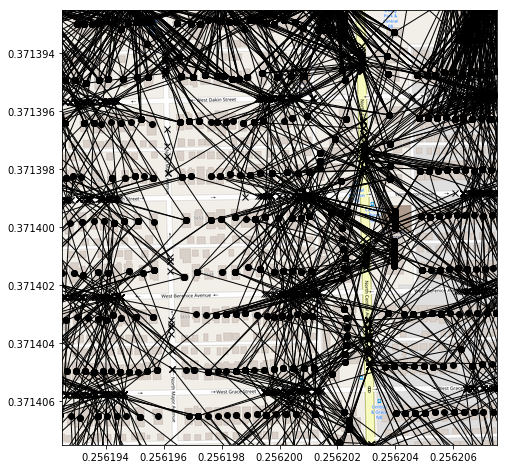

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
ex = tilemapbase.Extent.from_centre(0.2562, 0.3714, xsize=0.000015)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

plotter.plot(ax)
ax.scatter(*crime_pts_wm.T, marker="x", color="black", linewidth=1)
ax.scatter(*new_pts_wm.T, marker="o", color="black", linewidth=1)
ax.add_collection(matplotlib.collections.LineCollection(lines, linewidth=1, color="black"))